# Identify emerging and important projects related to Red Hat using graphical analysis

In the [graph analysis notebook](./graph_analysis.ipynb), we explored relationships between open source projects and communities by studying graphs. We explored relations such as common contributors and project activities between different GitHub repositories.

In this notebook, our aim is to leverage the graph representation techniques we explored in the previous notebook and apply algorithms such as PageRank, Betweenness Centrality to find important emerging projects for Red Hat.

## Datasets

* [red hat repos](../repo_lists/red_hat_repos.txt) - Repositories which are upstreams of Red Hat products, or Red Hat communities
* [red hat dependencies](../repo_lists/red_hat_dependencies.txt) - Upstream projects which are dependencies for Red Hat products
* [cncf projects](../repo_lists/cncf_projects.txt) - CNCF projects, some of which are also Red Hat product dependencies
* [potentially interesting projects](../repo_lists/other_repos.txt) - Any open source project which could be potentially interesting to Red Hat

## Connect to Augur database

We will be fetching the data from an Augur database which stores the GitHub data for a large number of open source repositories.

In [1]:
import sys
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import psycopg2
import itertools
from operator import itemgetter

import sqlalchemy as salc
import json
import networkx as nx

sys.path.append(os.path.join(sys.path[0], "../approaches"))

from ipynb.fs.full.graph_helper_functions import (
     get_repos,
     get_issue_contributors,
     get_pr_contributors,
     get_commit_contributors,
     get_prr_contributors,
     created_melted_dfs,
     get_repos_outside,
     get_page_ranks,
     get_betweenness_centrality,
     get_closeness_centrality,
     plot_graph,
     project_nodes_edges_contributions
)

with open("../../../comm_cage.json") as config_file:
    config = json.load(config_file)

In [2]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

In [3]:
READ_LOCALLY = True

## Retrieve Available Repositories for OpenShift and Kubernetes

We start by feeding an initial list of projects out of which we track projects in 2 categories:

1. Red Hat affiliated projects (which include upstream project mappings of Red Hat products), and
2. Projects of potential interest to Red Hat

In [4]:
with open('../repo_lists/red_hat_repos.txt', 'r') as f:
    rh_affiliated_projects = [line.strip() for line in f]

In [5]:
with open('../repo_lists/other_repos.txt', 'r') as f:
    interesting_projects = [line.strip() for line in f]

In [6]:
with open('../repo_lists/red_hat_dependencies.txt', 'r') as f:
    rh_dependencies = [line.strip() for line in f]

In [7]:
with open('../repo_lists/cncf_projects.txt', 'r') as f:
    cncf = [line.strip() for line in f]

In [8]:
repo_set_interesting, repo_git_interesting = get_repos(interesting_projects, engine)

In [9]:
repo_set_rh_affiliated, repo_git_rh_affiliated = get_repos(rh_affiliated_projects, engine)

In [10]:
repo_set_rh_dep, repo_git_rh_dep = get_repos(rh_dependencies, engine)

In [11]:
repo_set_cncf, repo_git_cncf = get_repos(cncf, engine)

In [12]:
org_repo_interesting = [x.split("https://github.com/", 1)[1] for x in repo_git_interesting]
org_repo_rh_affiliated = [x.split("https://github.com/", 1)[1] for x in repo_git_rh_affiliated]
org_repo_rh_dep = [x.split("https://github.com/", 1)[1] for x in repo_git_rh_dep]
org_repo_cncf = [x.split("https://github.com/", 1)[1] for x in repo_git_cncf]

In [13]:
org_repo_set = org_repo_interesting + org_repo_rh_affiliated + org_repo_rh_dep + org_repo_cncf

In [14]:
repo_set = repo_set_interesting + repo_set_rh_affiliated + repo_set_rh_dep + repo_set_cncf

In [15]:
len(repo_git_rh_affiliated)

1905

In [16]:
len(repo_git_interesting)

1007

In [17]:
len(repo_git_rh_dep)

82

In [18]:
len(repo_git_cncf)

59

### Retrieve Issue Contributors

We will now fetch all Issue contributors for various repositories.

In [19]:
if READ_LOCALLY:

    issue_contrib = pd.read_pickle("../ep_data/issue_contrib.pkl")
    issue_contrib['org_repo'] = issue_contrib['repo_git'].apply(lambda x: x.split("https://github.com/", 1)[1])

else:

    issue_contrib = get_issue_contributors(repo_set, engine)
    issue_contrib['created_at_dt'] = issue_contrib['created_at'].dt.date
    date_range = (issue_contrib['created_at_dt'] > pd.to_datetime('2011-01-01')) & (issue_contrib['created_at_dt'] <= pd.to_datetime('2014-06-30'))
    issue_contrib = issue_contrib.loc[date_range]
    issue_contrib['org_repo'] = issue_contrib['repo_git'].apply(lambda x: x.split("https://github.com/", 1)[1])
    issue_contrib.to_pickle("ep_data/issue_contrib.pkl")  

In [20]:
issue_contrib.head()

,repo_id,repo_git,repo_name,cntrb_id,action,issue_id,created_at,created_at_dt,org_repo
5058,32390,https://github.com/openshift/source-to-image,source-to-image,01000001-6200-0000-0000-000000000000,closed,124949,2014-05-22 18:00:49,2014-05-22,openshift/source-to-image
5059,32390,https://github.com/openshift/source-to-image,source-to-image,010004c7-9000-0000-0000-000000000000,closed,125140,2014-04-22 07:24:09,2014-04-22,openshift/source-to-image
6433,32549,https://github.com/openshift/vagrant-openshift,vagrant-openshift,010000ac-6800-0000-0000-000000000000,closed,332865,2014-05-19 09:59:34,2014-05-19,openshift/vagrant-openshift
6434,32549,https://github.com/openshift/vagrant-openshift,vagrant-openshift,01000785-c200-0000-0000-000000000000,closed,332854,2013-12-20 10:37:43,2013-12-20,openshift/vagrant-openshift
6462,32549,https://github.com/openshift/vagrant-openshift,vagrant-openshift,01000785-c200-0000-0000-000000000000,closed,332847,2014-05-27 11:56:24,2014-05-27,openshift/vagrant-openshift


### Retrieve PR Contributors

We will now fetch all the PR contributors for various repositories.

In [21]:
if READ_LOCALLY:

    pr_contrib = pd.read_pickle("../ep_data/pr_contrib.pkl")
    pr_contrib['org_repo'] = pr_contrib['repo_git'].apply(lambda x: x.split("https://github.com/", 1)[1])

else:

    pr_contrib = get_pr_contributors(repo_set, engine)
    pr_contrib['created_at_dt'] = pr_contrib['pr_created_at'].dt.date
    date_range = (pr_contrib['created_at_dt'] > pd.to_datetime('2011-01-01')) & (pr_contrib['created_at_dt'] <= pd.to_datetime('2014-06-30'))
    pr_contrib = pr_contrib.loc[date_range]
    pr_contrib['org_repo'] = pr_contrib['repo_git'].apply(lambda x: x.split("https://github.com/", 1)[1])
    pr_contrib.to_pickle("ep_data/pr_contrib.pkl")

In [22]:
pr_contrib.head()

,repo_id,repo_git,repo_name,cntrb_id,pull_request_id,pr_created_at,created_at_dt,org_repo
139635,32414,https://github.com/openshift/jboss-as7-modules,jboss-as7-modules,010005fe-ad00-0000-0000-000000000000,852920,2012-02-28 14:53:03,2012-02-28,openshift/jboss-as7-modules
139636,32414,https://github.com/openshift/jboss-as7-modules,jboss-as7-modules,01000511-b200-0000-0000-000000000000,852923,2012-05-15 05:25:37,2012-05-15,openshift/jboss-as7-modules
139637,32414,https://github.com/openshift/jboss-as7-modules,jboss-as7-modules,01000c17-1100-0000-0000-000000000000,852920,2012-02-28 14:53:03,2012-02-28,openshift/jboss-as7-modules
139638,32414,https://github.com/openshift/jboss-as7-modules,jboss-as7-modules,010005fe-ad00-0000-0000-000000000000,852921,2012-02-16 15:38:43,2012-02-16,openshift/jboss-as7-modules
139639,32414,https://github.com/openshift/jboss-as7-modules,jboss-as7-modules,01000c17-1100-0000-0000-000000000000,852923,2012-05-15 05:25:37,2012-05-15,openshift/jboss-as7-modules


### Retrieve Commit Contributors

We will now fetch all the Commit contributors for various repositories.

In [23]:
if READ_LOCALLY:

    commit_contrib = pd.read_pickle("../ep_data/commit_contrib.pkl")
    commit_contrib['org_repo'] = commit_contrib['repo_git'].apply(lambda x: x.split("https://github.com/", 1)[1])


else:

    commit_contrib = get_commit_contributors(repo_set, engine)
    commit_contrib['cmt_date_attempted_dt'] = commit_contrib['cmt_date_attempted'].dt.date
    date_range = (commit_contrib['cmt_date_attempted_dt'] > pd.to_datetime('2011-01-01')) & (commit_contrib['cmt_date_attempted_dt'] <= pd.to_datetime('2014-06-30'))
    commit_contrib = commit_contrib.loc[date_range]
    commit_contrib['org_repo'] = commit_contrib['repo_git'].apply(lambda x: x.split("https://github.com/", 1)[1])
    commit_contrib.to_pickle("ep_data/commit_contrib.pkl")  

In [24]:
commit_contrib.head()

,repo_id,repo_git,repo_name,cntrb_id,cmt_id,cmt_date_attempted,cmt_date_attempted_dt,org_repo
12993,35833,https://github.com/RedHatInsights/go-difflib,go-difflib,010015d4-fb00-0000-0000-000000000000,3856746,2013-10-21,2013-10-21,RedHatInsights/go-difflib
12994,35833,https://github.com/RedHatInsights/go-difflib,go-difflib,010015d4-fb00-0000-0000-000000000000,3856747,2013-10-21,2013-10-21,RedHatInsights/go-difflib
12997,35833,https://github.com/RedHatInsights/go-difflib,go-difflib,010015d4-fb00-0000-0000-000000000000,3856757,2013-11-23,2013-11-23,RedHatInsights/go-difflib
12998,35833,https://github.com/RedHatInsights/go-difflib,go-difflib,010015d4-fb00-0000-0000-000000000000,3856758,2013-11-23,2013-11-23,RedHatInsights/go-difflib
13003,35833,https://github.com/RedHatInsights/go-difflib,go-difflib,010015d4-fb00-0000-0000-000000000000,3856760,2013-10-27,2013-10-27,RedHatInsights/go-difflib


### Retrieve PR Reviewers 

We will now fetch all the PR Reviewers for various repositories.

In [25]:
if READ_LOCALLY:

    prr_contrib = pd.read_pickle("../ep_data/prr_contrib.pkl")
    prr_contrib['org_repo'] = prr_contrib['repo_git'].apply(lambda x: x.split("https://github.com/", 1)[1])


else:

    prr_contrib = get_prr_contributors(repo_set, engine)
    prr_contrib['org_repo'] = prr_contrib['repo_git'].apply(lambda x: x.split("https://github.com/", 1)[1])
    prr_contrib.to_pickle("ep_data/prr_contrib.pkl")  

In [26]:
prr_contrib.head()

,repo_id,repo_git,repo_name,cntrb_id,pull_request_id,org_repo
0,35874,https://github.com/RedHatInsights/approval-pro...,approval-process,0100c4d7-9a00-0000-0000-000000000000,810268,RedHatInsights/approval-process
1,35874,https://github.com/RedHatInsights/approval-pro...,approval-process,01006b89-9b00-0000-0000-000000000000,810290,RedHatInsights/approval-process
2,35874,https://github.com/RedHatInsights/approval-pro...,approval-process,01000282-cd00-0000-0000-000000000000,810325,RedHatInsights/approval-process
3,35874,https://github.com/RedHatInsights/approval-pro...,approval-process,01006b89-9b00-0000-0000-000000000000,810299,RedHatInsights/approval-process
4,36052,https://github.com/RedHatInsights/vulnerabilit...,vulnerability-engine,01006579-5400-0000-0000-000000000000,55371876,RedHatInsights/vulnerability-engine


## Graph Type 1: Projects and Contributors as Nodes

In this section, we plot projects and contributors on the same graph as nodes and color them differently to see the relationships between them.

### Commit Contributors

In [27]:
df_commit = commit_contrib.groupby(['org_repo', 'cntrb_id']).size().unstack(fill_value=0)
df_commit.head()

cntrb_id,01000000-0700-0000-0000-000000000000,01000000-1400-0000-0000-000000000000,01000000-1500-0000-0000-000000000000,01000000-1b00-0000-0000-000000000000,01000000-2500-0000-0000-000000000000,01000000-2e00-0000-0000-000000000000,01000000-4700-0000-0000-000000000000,01000000-6500-0000-0000-000000000000,01000000-6c00-0000-0000-000000000000,01000000-bf00-0000-0000-000000000000,...,01064248-0600-0000-0000-000000000000,010669c9-ca00-0000-0000-000000000000,01066a19-4800-0000-0000-000000000000,010685af-7f00-0000-0000-000000000000,0106b6a6-8000-0000-0000-000000000000,0106f587-7600-0000-0000-000000000000,0106ff78-e000-0000-0000-000000000000,01070d47-3700-0000-0000-000000000000,0107160e-6100-0000-0000-000000000000,010766ba-bb00-0000-0000-000000000000
org_repo,,,,,,,,,,,,,,,,,,,,,
CentOS/CentOS-events,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CentOS/Community-Kickstarts,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CentOS/ImageStandards,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CentOS/official-images,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CentOS/sig-cloud-instance-build,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In the above dataframe, each row represents a repository ID and each column represents a contributor. The dataframe contains counts for the number of times a contributor has made contributions to a particular repository. In the dataframe below `df_commit`, each contribution represents a commit. A value 0 means that a particular contributor has made no commits to the repository, and a a number x means that the contributor has made x number of commits to the repository.

In [28]:
df_commit = df_commit.reset_index()
df_melted_commit = df_commit.melt(
    ['org_repo'],
    var_name = 'cntrb_id',value_name='number')
df_melted_commit = df_melted_commit[df_melted_commit[df_melted_commit.columns[2]] != 0]
df_melted_commit.head()

,org_repo,cntrb_id,number
419,docker/docs,01000000-0700-0000-0000-000000000000,2
532,openshift/moby-moby,01000000-0700-0000-0000-000000000000,2
1010,docker/docs,01000000-1400-0000-0000-000000000000,2
1123,openshift/moby-moby,01000000-1400-0000-0000-000000000000,2
1685,etcd-io/etcd,01000000-1500-0000-0000-000000000000,22


In `df_melted_commit` we transpose the contributor IDs. Each row is a combination of a unique repository and a unique contributor and the number represents the number of times the contributor has made contributors to the particular repository.

#### Create melted dataframes for all contribution type dataframes

In [29]:
df_melted_pr_contrib = created_melted_dfs(pr_contrib)
df_melted_issue_contrib = created_melted_dfs(issue_contrib)
df_melted_prr_contrib = created_melted_dfs(prr_contrib)

### Join repositories of all contribution types

Combine dataframes of Issue contributors, PR contributors, PR Reviewers, and Commit Contributors to get aggregated contributor dataframes for each repository

In [30]:
commit_issue = pd.concat([df_melted_commit, df_melted_issue_contrib]).groupby(["org_repo", "cntrb_id"]).sum().reset_index()
comm_issue_pr_df = pd.concat([df_melted_pr_contrib, commit_issue]).groupby(["org_repo", "cntrb_id"]).sum().reset_index()
merged_df = pd.concat([comm_issue_pr_df, df_melted_prr_contrib]).groupby(["org_repo", "cntrb_id"]).sum().reset_index()
merged_df.rename(columns = {'number':'total_contributions'}, inplace = True)

In [31]:
merged_df.head()

,org_repo,cntrb_id,total_contributions
0,3scale/3scale-amp-openshift-templates,0100025b-cb00-0000-0000-000000000000,2
1,3scale/3scale-amp-openshift-templates,01000314-4200-0000-0000-000000000000,1
2,3scale/3scale-amp-openshift-templates,01000d73-7900-0000-0000-000000000000,1
3,3scale/3scale-amp-openshift-templates,010011d9-8100-0000-0000-000000000000,2
4,3scale/3scale-amp-openshift-templates,01001362-3800-0000-0000-000000000000,1


### Plot Graphs

### Use PageRank and Betweenness Centrality to Subset Nodes

* We will use `PageRank` algorithm to compute the ranks of the nodes in the graph based on the structure of the incoming links. 

* We will also compute the `Betweenness centrality` scores for each node to measures how often a node occurs on all shortest paths between two nodes. Here we are trying to analyze which are the common repositories that occur on all paths in the graph. 

### Page Rank

PageRank ranks important nodes by analyzing the quantity and quality of the links that point to it. In our case, links that point to repositories come from contributors. 

In [32]:
repo_scores = pd.DataFrame(
    {'repo': org_repo_rh_affiliated+org_repo_interesting+org_repo_rh_dep+org_repo_cncf
    })

In [33]:
#  A unidirected graph from contributors to repositories will not be able to assign importances to well connected contributors. 
#  Hence we will create a bidirected graph where for each connection between a contributor and a repository, there is a 2 way arrow.
bidirect_df = merged_df.append(merged_df.rename(columns={"org_repo":"cntrb_id", "cntrb_id":"org_repo"}))

In [34]:
# Creating a directed graph to run page rank
H = nx.from_pandas_edgelist(bidirect_df,
                            source='cntrb_id',
                            target='org_repo',
                            edge_attr='total_contributions',
                            create_using=nx.DiGraph())

In [35]:
repos = {"repo_name_set_rh_affiliated": org_repo_rh_affiliated, "repo_name_set_interesting": org_repo_interesting, "repo_name_set_rh_dep": org_repo_rh_dep, "repo_name_set_cncf":org_repo_cncf}

In [36]:
top_repos, pageranks, repo_scores = get_page_ranks(H, 100, repos, repo_scores)

In [37]:
topnodes = dict(sorted(pageranks.items(), key = itemgetter(1), reverse = True)[:100])
key = topnodes.keys()
subgraph = nx.subgraph(H, key)

In [38]:
t = "Top 100 repos by page rank"

We want to give higher priority to outgoing nodes. So we take 50 nodes with lowest pagerank (most number of connections)

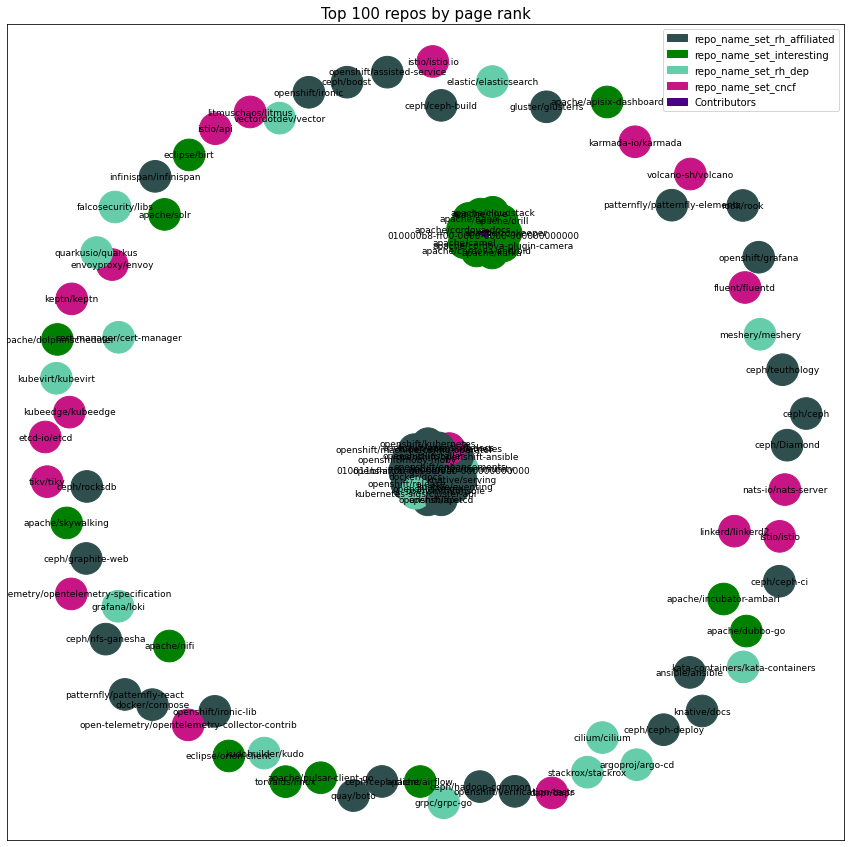

In [39]:
plot_graph(subgraph, repos, 'conditional', t, org_repo_set , True, None, 'k')

***What do we see in this plot?***

We see that there are some repos from all categories that are highly ranked by Pagerank.

Note: The PageRank algorithm measures the importance of nodes by analyzing the quantity and quality of the links that point to it. So if a repository has a lot of contributors and especially if these contributors count as important nodes, they are still ranked high. 

### Betweenness centrality

Betweenness centrality analysis provides information about the node’s importance for an information flow or connectivity of the network. 
This is a good metric for us, as using this we are able to better capture relative importance of repositories. In our case since we start with examples of well-known repos, we can use this algorithm to find other repos which are important in connection to these well-known repos.

In [40]:
G = nx.from_pandas_edgelist(merged_df, 
                            source='org_repo',
                            target='cntrb_id',
                            edge_attr='total_contributions',
                            create_using=nx.Graph())

In [41]:
top_repos, bc, repo_scores = get_betweenness_centrality(G, 100, repos, repo_scores)

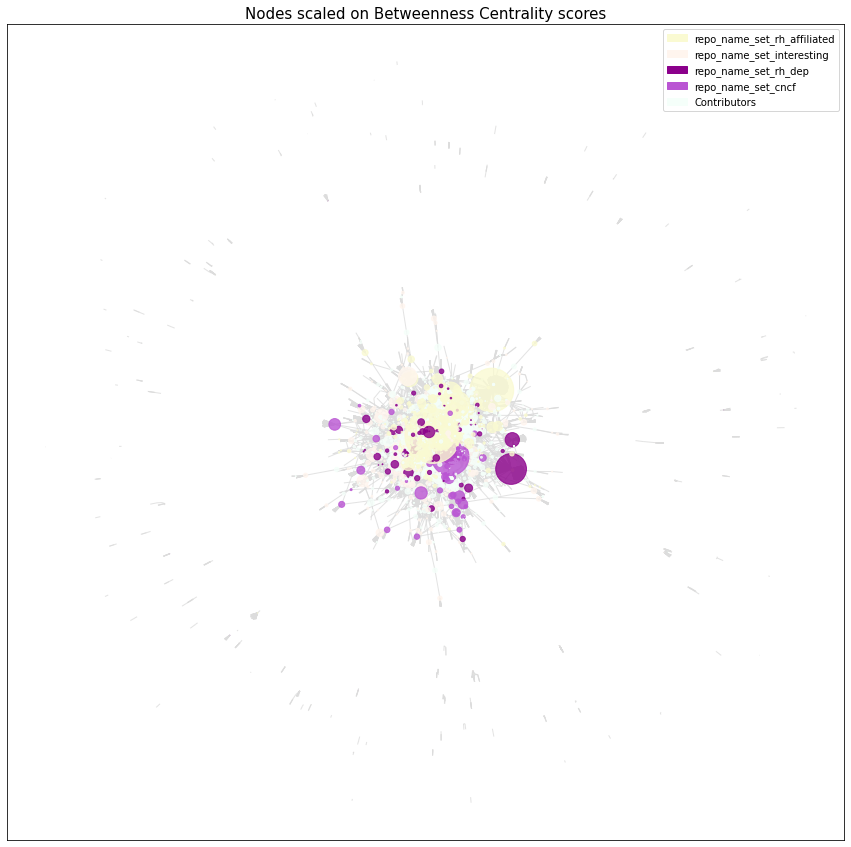

In [42]:
t = "Nodes scaled on Betweenness Centrality scores"
plot_graph(G, repos, 'weighted', t, bc, False, 0.8, "gainsboro")

## Graph Type 2: Nodes as projects edges as contributors

In [43]:
result, common_repo_contri = project_nodes_edges_contributions(merged_df)

For plotting the graph below, we pick the repositories as the nodes and let the shared contributions dictate the edge weights

In [44]:
g = nx.Graph()
g.add_weighted_edges_from(result)

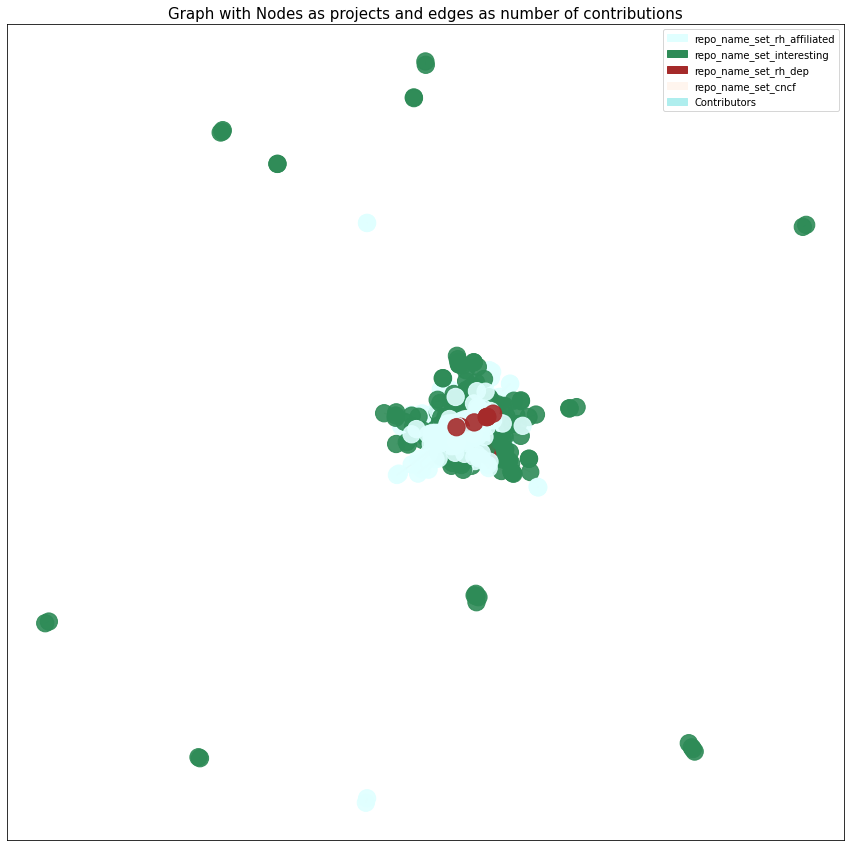

In [45]:
t = "Graph with Nodes as projects and edges as number of contributions"
plot_graph(g, repos, 'equal', t, None, False, 0.9, "gainsboro")

This is a lot of repositories and the graph is hard to read clearly. In this graph representation type, the further a node is to another node, they share less number of shared contributions. Thus, we can elimate some of the node connections or edges which are really long

### Lets eliminate the 30% of the furthest connections

In [46]:
sorted_contribution_dict = dict(sorted(common_repo_contri.items(), key=lambda item: item[1], reverse=True))

In [47]:
tightly_connected_repos = dict(itertools.islice(sorted_contribution_dict.items(), round(0.7*len(sorted_contribution_dict))))

### Community Detection

To get groups of clusters, lets look at larger congregations with more than 5 projects to get a cleaner view into the main networks

In [48]:
graphs = [g.subgraph(c) for c in nx.connected_components(g)]

In [49]:
sub_graphs = []
for g in graphs:
    n = g.nodes()
    if g.number_of_nodes() > 5 and (set(n) & set(org_repo_interesting)):
        sub_graphs.append(g)

In [50]:
sub_graphs

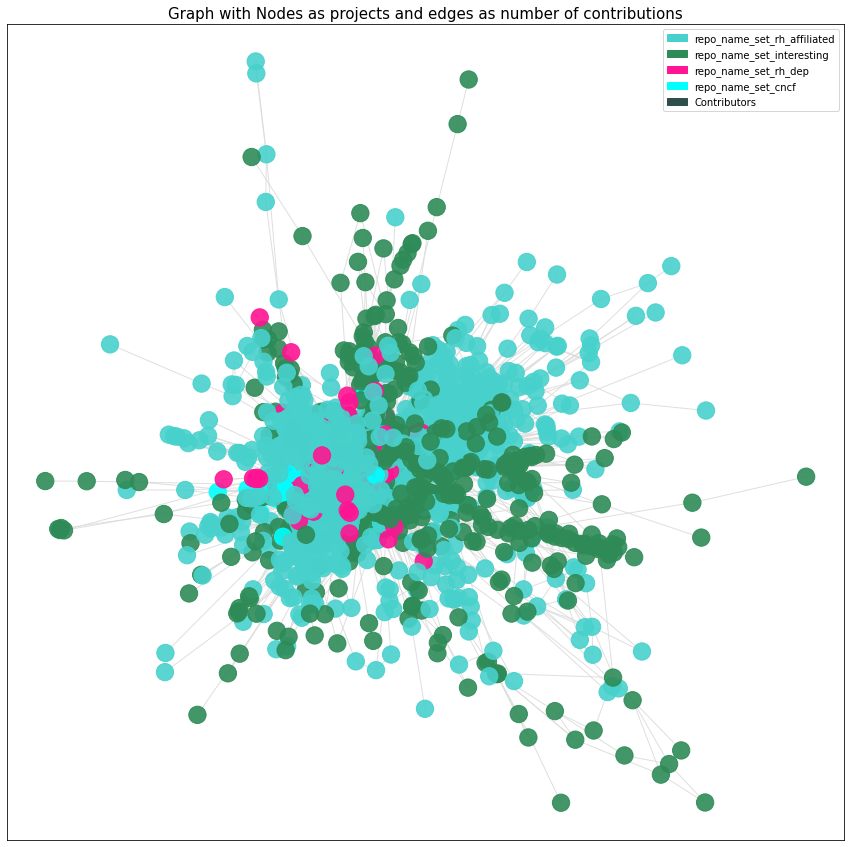

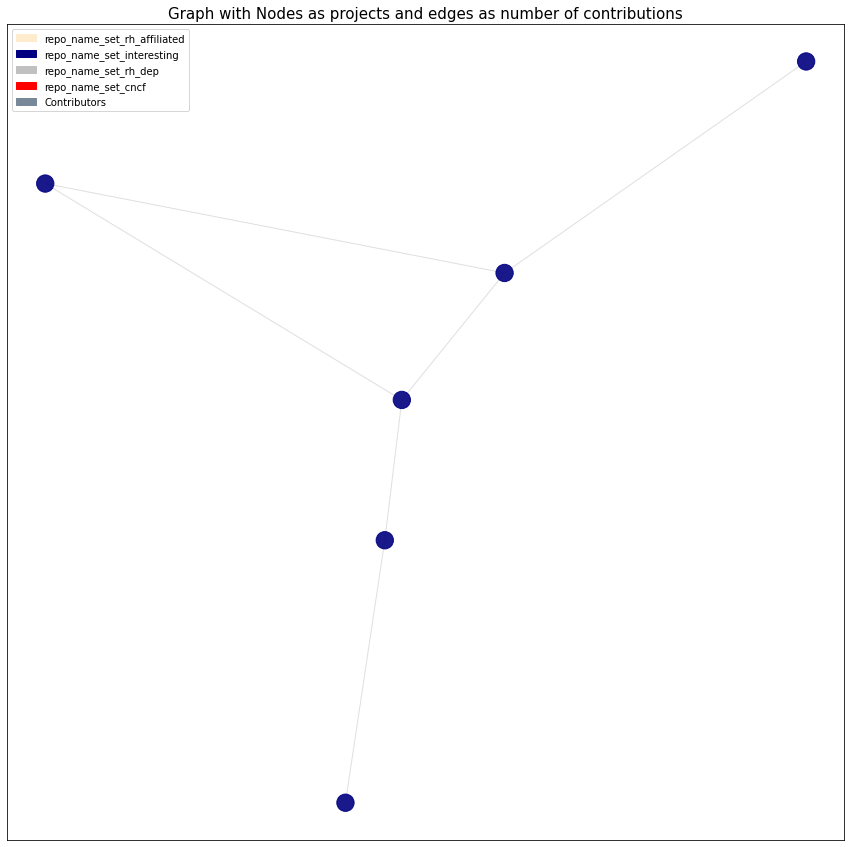

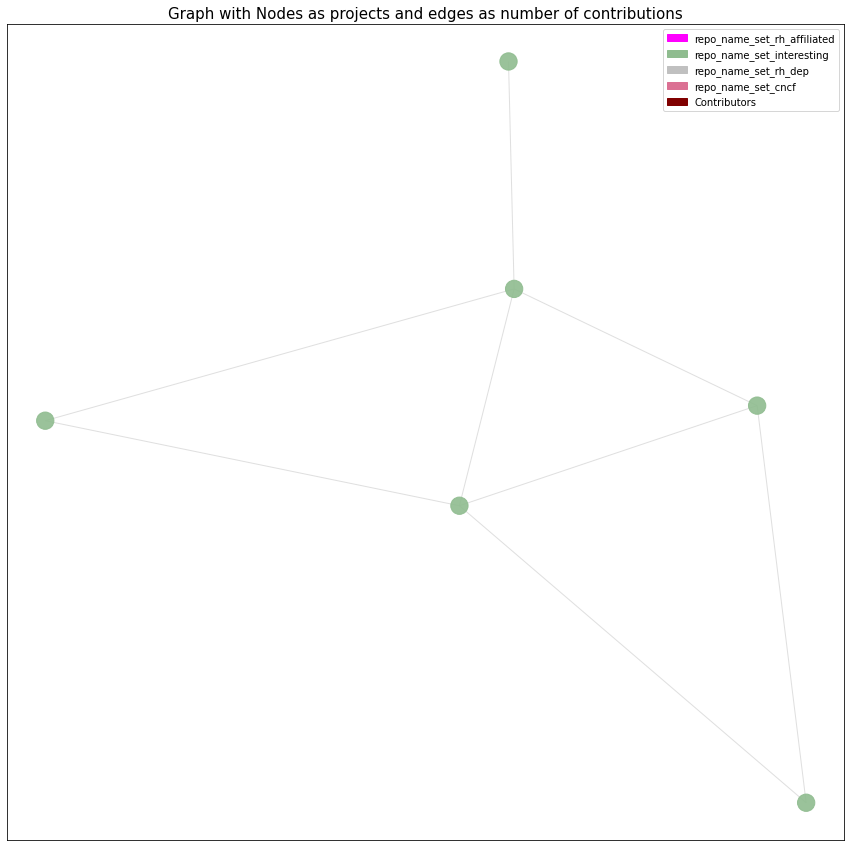

In [51]:
for graph in sub_graphs:
    plot_graph(graph, repos, 'equal', t, None , False, 0.9, "gainsboro")

In [52]:
top_repos, cc, repo_scores = get_closeness_centrality(sub_graphs[0], 100, repos, repo_scores)

In [53]:
repo_scores

,repo,page_rank,betweenness_centrality,closeness_centrality
0,RedHatInsights/approval-process,0.000039,0.000002,0.179923
1,RedHatInsights/clowder-hello,NaN,NaN,NaN
2,RedHatInsights/insights-inventory-frontend-build,NaN,NaN,NaN
3,RedHatInsights/logger-demo,NaN,NaN,NaN
4,RedHatInsights/vmaas-go,NaN,NaN,NaN
...,...,...,...,...
3048,open-telemetry/opentelemetry-java,0.000321,0.001920,0.209838
3049,keylime/keylime,0.000584,0.002851,0.274281
3050,strimzi/strimzi-kafka-operator,0.000601,0.004443,0.288644
3051,kubedl-io/kubedl,0.000134,0.000377,0.202389


## Top most interesting repos in each category based on the above scores

In [54]:
repo_scores = repo_scores.dropna(axis=0)

In [55]:
def category(col_val, repo_dict):
    for repo_group in repo_dict:  
        if col_val in repo_dict[repo_group]:
            return repo_group

In [66]:
repo_scores['category'] = repo_scores['repo'].apply(lambda row: category(row, repos))

In [57]:
scaler = MinMaxScaler()
def calculate_scores(df):
    df[['page_rank', 'betweenness_centrality', 'closeness_centrality']] = scaler.fit_transform(df[['page_rank', 'betweenness_centrality', 'closeness_centrality']])
    df['total_score'] = df.apply(lambda row: row.page_rank + row.betweenness_centrality + row.closeness_centrality, axis = 1)
    return df

In [65]:
repo_scores = calculate_scores(repo_scores)

In [59]:
repo_scores.head()

,repo,page_rank,betweenness_centrality,closeness_centrality,category,total_score
0,RedHatInsights/approval-process,0.000639,0.000006,0.286399,repo_name_set_rh_affiliated,0.287044
5,RedHatInsights/vulnerability-engine,0.003357,0.001184,0.408078,repo_name_set_rh_affiliated,0.412619
12,RedHatInsights/topological-inventory-frontend,0.000498,0.000008,0.402117,repo_name_set_rh_affiliated,0.402624
13,RedHatInsights/drift-backend,0.002177,0.000546,0.316841,repo_name_set_rh_affiliated,0.319564
16,RedHatInsights/insights-schemas-java,0.000822,0.000061,0.349682,repo_name_set_rh_affiliated,0.350565


In [60]:
top_repos = repo_scores.sort_values("total_score", ascending=False).groupby("category").head(20)

In [61]:
top_repos.loc[top_repos['category'] == 'repo_name_set_rh_affiliated', 'repo']

1886                      ansible/ansible
947                     openshift/release
1891                          docker/docs
622                   openshift/moby-moby
1794                            ceph/ceph
497              openshift/openshift-docs
516                     openshift/console
809                openshift/enhancements
965                      openshift/origin
1031                            quay/boto
994                   openshift/installer
1658                         ceph/Diamond
659               openshift/origin-server
1771                     ceph/ceph-client
726           openshift/openshift-ansible
1889                infinispan/infinispan
804                        openshift/etcd
996                     openshift/grafana
615     openshift/machine-config-operator
420                         openshift/odo
Name: repo, dtype: object

In [62]:
top_repos.loc[top_repos['category'] == 'repo_name_set_interesting', 'repo']

2904                   torvalds/linux
2693                     apache/camel
2583                apache/deltaspike
2452                apache/cloudstack
2585           apache/cordova-android
2157             eclipse/microprofile
2905                  sigstore/cosign
2246                  eclipse/reddeer
1967                 eclipse/che-docs
1991              eclipse/che-website
1992     eclipse/che-workspace-loader
2512                     apache/kafka
2085            eclipse/jetty.project
2712                 apache/zookeeper
1998            eclipse/codewind-docs
2801                      apache/nano
2196                      eclipse/omr
2520                   apache/airflow
1975        eclipse/che-plugin-broker
1984    eclipse/che-theia-java-plugin
Name: repo, dtype: object

In [63]:
top_repos.loc[top_repos['category'] == 'repo_name_set_cncf', 'repo']

3036             kubernetes/kubernetes
3030                      etcd-io/etcd
3013                    istio/istio.io
3010                       istio/istio
3035                    fluent/fluentd
3050    strimzi/strimzi-kafka-operator
3001                litmuschaos/litmus
3017                  envoyproxy/envoy
3031                         helm/helm
3049                   keylime/keylime
2999                 kubeedge/kubeedge
3039                 kubeedge/kubeedge
2997                karmada-io/karmada
3015                       istio/tools
3005                   tinkerbell/tink
3052               openservicemesh/osm
3012                       istio/proxy
3038                  thanos-io/thanos
3029                  thanos-io/thanos
3007                volcano-sh/volcano
Name: repo, dtype: object

In [64]:
top_repos.loc[top_repos['category'] == 'repo_name_set_rh_dep', 'repo']

2986                       elastic/elasticsearch
2954                        kubernetes/community
2989                           kubevirt/kubevirt
2923                             meshery/meshery
2946                          falcosecurity/libs
2987                         opencontainers/runc
2971                 kubernetes-sigs/cluster-api
2919                                 kiali/kiali
2966                            argoproj/argo-cd
3037                            argoproj/argo-cd
2958                            tektoncd/catalog
2968             kata-containers/kata-containers
2992    kubevirt/hyperconverged-cluster-operator
2913                               cilium/cilium
2970                       kata-containers/tests
2993                   kubevirt/kubevirt-ansible
2933                             backube/volsync
2980                               jakartaee/cdi
2920                            kudobuilder/kudo
2929                      ovn-org/ovn-kubernetes
Name: repo, dtype: o